In [1]:
import tensorflow as tf
import h5py
import numpy as np
import scipy.misc
import random
import matplotlib.pyplot as plt
import os
import lmdb
import sys

## File Names

In [2]:
LMDB_DATA_PATH = 'Regression_data/TrainDataOffset'
LMDB_LABEL_PATH = 'Regression_data/TrainLabelOffset'

## Dataset name within the hdf5 file

In [3]:
dataset_labels_ = []
dataset_images_ = []
env = lmdb.open(LMDB_DATA_PATH, readonly=True)
env2 = lmdb.open(LMDB_LABEL_PATH, readonly=True)

### Grab the first 1000 images from our LMDB to check 

In [4]:
with env.begin(  ) as txn:
    cursor = txn.cursor()    
    counter = 0
    for key, value in cursor:        
    
        if (counter == 50000):
            break
        #print(key, np.frombuffer(value, dtype=np.float32))
        #print(key, value)
        key_str = key.decode('ascii')
        #print(txn.stat())
        #xx = (txn.get(key))
        
        #dataset_images_.append(np.frombuffer(xx, dtype=np.float32).reshape([120,120,3]))
        #print(dataset_images_)
        if 'label' in key_str:
            #print('Label size:', len(value))            
        #    dataset_labels_.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
            pass
        else:
            # Must be images            
            #print('Image size:', len(value))
            # Get shape information from key name
            info_key = key_str.split('_')
            #print(info_key)
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))       
            #print(shape_img)
            dataset_images_.append(np.frombuffer(value, dtype=np.float32).reshape(shape_img))
            
            
        counter += 1
    

### Grab the all labels from our other LMDB

In [5]:
with env2.begin() as txn2:
    cursor2 = txn2.cursor()    
    counter2 = 0
    for key, value in cursor2:        
    
        #if (counter2 == 1000):
        #    break
        
        #print(key, np.frombuffer(value, dtype=np.float32))
        #print(key, value)
        key_str = key.decode('ascii')
        
        
        if 'label' in key_str:
            #print('Label size:', len(value))            
            #dataset_labels_.append(np.float32(np.asscalar(np.frombuffer(value, dtype=np.float32, count=1))))
            dataset_labels_.append(np.frombuffer(value, dtype=np.float32).reshape([1,2]))
            
        else:
            # Must be images            
            #print('Image size:', len(value))
            # Get shape information from key name
            info_key = key_str.split('_')
            #print(info_key)
            # Get image shape [2:None] means from index 2 to the end
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))            
            dataset_images_.append(np.frombuffer(value, dtype=np.float32).reshape(shape_img))
            
        #counter2 += 1

Y_ = np.asarray(dataset_labels_)
Y_ = np.squeeze(Y_,1)
Y_ = Y_*10
no_images = len(Y_)  
print(no_images)

372624


### Check we have loaded correctly and display

Number of labels on lmdb: 372624
Number of images on lmdb: 50000
[[ 0.133 -0.089]]


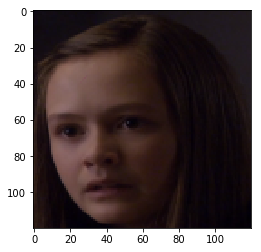

(372624, 2)
[ 1.33000004 -0.88999999]
(50000, 120, 120, 3)


In [6]:
print('Number of labels on lmdb:',len(dataset_labels_))
print('Number of images on lmdb:',len(dataset_images_))
print(dataset_labels_[999])
plt.imshow(dataset_images_[999])
plt.show()
print(Y_.shape)
print(Y_[999])
dataset_images_ = np.asarray(dataset_images_)
print(dataset_images_.shape)

## Histogram of label distribution

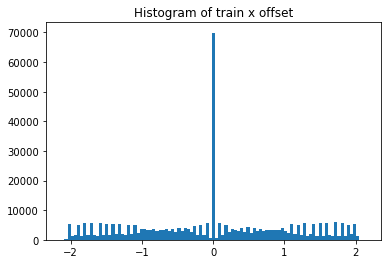

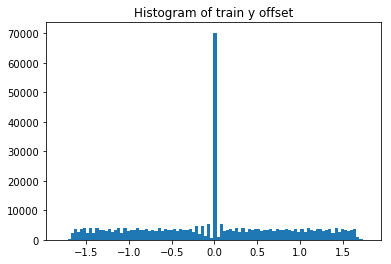

In [7]:
plt.hist(Y_[:,0], bins='auto')
plt.title("Histogram of train x offset")
plt.show()
plt.hist(Y_[:,1], bins='auto')
plt.title("Histogram of train y offset")
plt.show()

#plt.hist(Y_test[:,0], bins='auto')
#plt.title("Histogram of test x offset")
#plt.show()
#plt.hist(Y_test[:,1], bins='auto')
#plt.title("Histogram of test y offset")
#plt.show()

# Tensorflow Training

##### Start our 'session' (these are the connection between the c++ backend and python. Common usage in TF is to create your graph then launch it in a session

In [8]:
import model_util as util
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.8)
sess = tf.InteractiveSession(config=tf.ConfigProto(gpu_options=gpu_options))

In [9]:
# Placeholders for our input variables, None indicates batch size is variable
x = tf.placeholder(tf.float32, shape=[None, 120, 120, 3 ])
y_ = tf.placeholder(tf.float32, shape=[None, 2])

dropout_prob = tf.placeholder(tf.float32)
x_image = x

##### Define our model (uses model_util.py to help define conv2d etc.)

In [10]:
# Conv1 
conv1 = util.conv2d(x_image, 5, 5, 3, 24, 2,"conv1",True)

# CONV 2
conv2 = util.conv2d(conv1, 5, 5, 24, 36, 2,"conv2")

# CONV 3
conv3 = util.conv2d(conv2, 5, 5, 36, 48, 2,"conv3")

# CONV 4
conv4 = util.conv2d(conv3, 3, 3, 48, 64, 1, "conv4")

# CONV 5
conv5 = util.conv2d(conv4, 3, 3, 64, 64, 1, "conv5")

# Fully Connect 1
# Needs calculation... (-1 means any batch size)
conv5_flat = tf.reshape(conv5, [-1, 14400])

fc1 = util.fc_layer(conv5_flat, 14400, 1164, "fc1")
# Add dropout to the fully connected layer
fc1_drop = tf.nn.dropout(fc1,dropout_prob )

# Fully Connect 2
fc2 = util.fc_layer(fc1_drop, 1164, 100, "fc2")
# Add dropout to the fully connected layer
fc2_drop = tf.nn.dropout(fc2, dropout_prob)

# Fully Connect 3
fc3 = util.fc_layer(fc2_drop, 100, 50, "fc3")
# Add dropout to the fully connected layer
fc3_drop = tf.nn.dropout(fc3, dropout_prob)

# Fully Connect 4
fc4 = util.fc_layer(fc3_drop, 50, 10, "fc4")
# Add dropout to the fully connected layer
fc4_drop = tf.nn.dropout(fc4, dropout_prob)

#Output
out_layer = util.output_layer(fc4_drop, 10, 2, "output_layer")

y = out_layer

### HyperParams, losses and solver set up

In [11]:
L2NormConst = 0.001
start_lr = 0.0001
epochs = 300
batch_size = 250

train_vars = tf.trainable_variables()

with tf.name_scope("MSE_Loss_L2Reg"):
        loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n(
[tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst
        
with tf.name_scope("Loss_Validation"):
    loss_val = tf.reduce_mean(tf.square(tf.subtract(y_,y)))

with tf.name_scope("Solver"):
    global_step = tf.Variable(0, trainable=False)
    starter_learning_rate = start_lr
    
    # decay every 10000 steps with a base of 0.96
    learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step,
                                               10000, 0.96, staircase=True)

    train_step = tf.train.AdamOptimizer(learning_rate).minimize(loss, global_step=global_step)

sess.run(tf.global_variables_initializer())

# Set max_to_keep to 0 to save all checkpoints
saver = tf.train.Saver(max_to_keep=0)

tf.summary.scalar("loss_train", loss)
tf.summary.scalar("loss_val", loss_val)
tf.summary.scalar("learning_rate", learning_rate)
tf.summary.scalar("global_step", global_step)
merged_summary_op = tf.summary.merge_all()
summary_writer = tf.summary.FileWriter("C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/check")
summary_writer.add_graph(sess.graph)

In [12]:
save_dir = '.\check'
os.path.exists(save_dir)

True

### Training Loop 

In [13]:
env3 = lmdb.open(LMDB_DATA_PATH, readonly=True)

# Do our desired amount of epochs
for epoch in range(epochs):
    
    xs_ = []
    print(epoch, "start")
    
    with env3.begin() as txn3:
        cursor = txn3.cursor()    
        counter = 0
        
        # Load a batch of data
        for key, value in cursor:
        
            if counter == 350001:
                break
            
            if counter % 10000 == 0:
                print(counter)
                
            key_str = key.decode('ascii')
            info_key = key_str.split('_')
            shape_img = tuple(map(lambda x:int(x) ,info_key[2:None]))
            xs_.append(np.frombuffer(value, dtype=np.float32).reshape(shape_img))
            
            counter += 1
                          
            # When we have loaded a batch then do a train step on it
            if (counter % batch_size == 0):
                xs = np.asarray(xs_)
                ys = Y_[counter-batch_size:counter,:]
                #print(xs.shape)
                #print(ys[0,:])
                
                train_step.run(feed_dict={x: xs, y_: ys, dropout_prob: 0.8})
                summary = merged_summary_op.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
                summary_writer.add_summary(summary, epoch * batch_size + counter)
                xs_ = [] 
                              
    loss_value = loss_val.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
    print(epoch, ":", loss_value)
    checkpoint_path = os.path.join(save_dir, "model-ckpt")
    filename = saver.save(sess, checkpoint_path, epoch)   
 


0 start
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
0 : 0.105539
INFO:tensorflow:.\check\model-ckpt-0 is not in all_model_checkpoint_paths. Manually adding it.
1 start
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
1 : 0.0665263
INFO:tensorflow:.\check\model-ckpt-1 is not in all_model_checkpoint_paths. Manually adding it.
2 start
0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
2 : 0.0529745
INFO:tensorflow:.\check\model-c

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\ricbur01\AppData\Local\conda\conda\envs\py35\lib\site-packages\IPython\core\interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-54318b21c5dc>", line 37, in <module>
    summary = merged_summary_op.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
  File "C:\Users\ricbur01\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 569, in eval
    return _eval_using_default_session(self, feed_dict, self.graph, session)
  File "C:\Users\ricbur01\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\framework\ops.py", line 3741, in _eval_using_default_session
    return session.run(tensors, feed_dict)
  File "C:\Users\ricbur01\AppData\Local\conda\conda\envs\py35\lib\site-packages\tensorflow\python\client\session.py", line 778, in run
    run_metadata_ptr)
  File "C:\Users\ricbur01\AppData\Local\conda\conda\envs

KeyboardInterrupt: 

In [ ]:
Y_train = Y_[0:50000]
print(Y_train.shape)

for epoch in range(epochs):

    for i in range(int(50000/ batch_size)):
        
        xs = dataset_images_[i:i+batch_size,:,:,:]
        ys = Y_train[i:i+batch_size,:]
    
        train_step.run(feed_dict={x: xs, y_: ys, dropout_prob: 0.8})
        
        summary = merged_summary_op.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
        summary_writer.add_summary(summary, epoch * batch_size + i)
    
    
    
    loss_value = loss_val.eval(feed_dict={x: xs, y_: ys, dropout_prob: 1.0})
    print(epoch, ":", loss_value)
    checkpoint_path = os.path.join(save_dir, "model-ckpt")
    filename = saver.save(sess, checkpoint_path, epoch)
    

### Test an image

In [14]:
# Restore our model

#sess = tf.InteractiveSession()
saver = tf.train.Saver()
saver.restore(sess, "C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/check/model-ckpt-37")


INFO:tensorflow:Restoring parameters from C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/check/model-ckpt-37


INFO:tensorflow:Restoring parameters from C:/Users/ricbur01/Work/Tensorflow/MNist_1.0/check/model-ckpt-37


[[ 0.12   -0.0476]]


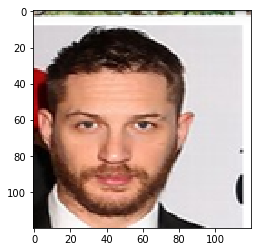

In [57]:
test_im_no = 4
print(dataset_labels_[test_im_no])
plt.imshow(dataset_images_[test_im_no])
plt.show()
test_im = dataset_images_[test_im_no]
test_im = test_im[np.newaxis,...]

In [58]:
pred_offset = (y.eval(feed_dict={x: test_im, dropout_prob:1}))/10
print("predicted x,y offset:", pred_offset)
offset = dataset_labels_[test_im_no]
print("label offset:", offset)

predicted x,y offset: [[ 0.12391242 -0.04437894]]
label offset: [[ 0.12   -0.0476]]


In [59]:
x_add = (120*pred_offset[0,0])
y_add = (120*pred_offset[0,1])
print(np.round(x_add), np.round(y_add))

15.0 -5.0


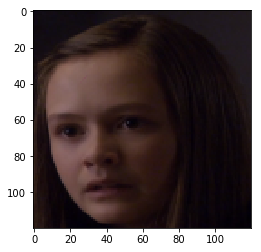

(120, 120, 3)


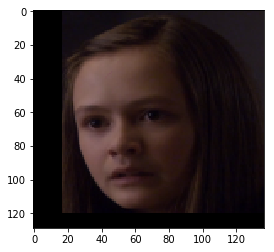

In [62]:
plt.imshow(dataset_images_[999])
plt.show()
new_im = np.zeros([129,137,3])
test_im3 = dataset_images_[999]
print(test_im3.shape)
new_im[0:120,17:,:]=test_im3
plt.imshow(new_im)
plt.show()